In [ ]:
#!pip install --upgrade numpy
#!pip install --upgrade pandas
#!pip install --upgrade tensorflow
#!pip install --upgrade mediapipe opencv-python scipy

In [ ]:
#!pip install numpy==1.24.4 protobuf==3.20.3 thinc==8.1.0 grpcio-status==1.54.0 ydf==0.9.0

#!pip install mediapipe thinc grpcio-status ydf sounddevice

In [1]:
!pip install mediapipe opencv-python matplotlib pandas scipy protobuf==3.20.3

In [ ]:
!pip uninstall protobuf
!pip install protobuf>=5.29.1,<6.0.0

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
import seaborn as sns
sns.set(style="whitegrid")

In [15]:
walk_video_path = '/content/Walk.mov'
calib_video_path = '/content/Calibration.mov'
checkerboard_sizes = [(8, 6, 0.085), (5, 4, 0.035)]
square_size_m = 0.085

In [26]:
# === CALIBRATION ===
cap = cv2.VideoCapture(calib_video_path)
objpoints, imgpoints = [], []
valid_gray = None
frame_idx = 0
found_any = False

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    for size_tuple in checkerboard_sizes:
        size = (size_tuple[0], size_tuple[1])
        square_size = size_tuple[2]
        objp = np.zeros((size[0]*size[1], 3), np.float32)
        objp[:, :2] = np.mgrid[0:size[0], 0:size[1]].T.reshape(-1, 2) * square_size

        found, corners = cv2.findChessboardCorners(gray, size, flags=cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE)
        if found:
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1),
                                        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            objpoints.append(objp)
            imgpoints.append(corners2)
            valid_gray = gray.copy()
            found_any = True
    frame_idx += 1
cap.release()

if not found_any or not imgpoints or valid_gray is None:
    raise RuntimeError(" Calibration failed: No checkerboard detected. Try adjusting checkerboard_size or improving lighting in the video.")

print(f"\n Total checkerboard frames used: {len(imgpoints)}")
ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, valid_gray.shape[::-1], None, None)
R, _ = cv2.Rodrigues(rvecs[0])
tvec = tvecs[0]

# === PROJECT TO GROUND PLANE ===
def project_to_ground(px, py):
    image_pt = np.array([[px, py, 1]], dtype=np.float64).T
    invK = np.linalg.inv(cameraMatrix)
    ray_dir = R @ invK @ image_pt
    cam_origin = -R.T @ tvec
    s = -cam_origin[2, 0] / ray_dir[2, 0]
    ground_pt = cam_origin.flatten() + s * ray_dir.flatten()
    return ground_pt[:2]

# === POSE ESTIMATION ===
cap = cv2.VideoCapture(walk_video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
pose = mp.solutions.pose.Pose(model_complexity=2, min_detection_confidence=0.7, min_tracking_confidence=0.7)

heel_data = {'Left': [], 'Right': []}
LEFT_HEEL, RIGHT_HEEL = 29, 30
frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    t = frame_idx / fps
    frame_idx += 1
    results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results.pose_landmarks:
        lm = results.pose_landmarks.landmark
        for side, idx in [('Left', LEFT_HEEL), ('Right', RIGHT_HEEL)]:
            vis = lm[idx].visibility
            if vis > 0.5:
                px, py = lm[idx].x * frame.shape[1], lm[idx].y * frame.shape[0]
                heel_data[side].append((t, px, py))
cap.release()
pose.close()


 Total checkerboard frames used: 417


In [27]:
# === SMOOTHING + PROJECT TO WORLD ===
for foot in ['Left', 'Right']:
    arr = np.array(heel_data[foot])
    if len(arr):
        t, x, y = arr[:,0], arr[:,1], arr[:,2]
        window = min(21, max(5, len(x)//10 * 2 + 1))
        if len(x) >= window:
            x = savgol_filter(x, window, 3)
            y = savgol_filter(y, window, 3)
        world_xy = np.array([project_to_ground(px, py) for px, py in zip(x, y)])
        heel_data[foot] = np.column_stack([t, world_xy])

In [39]:
# === Heel Strike Detection ===
def detect_hs(t, x, min_gap=0.7):
    hs = []
    last_t = -np.inf
    for i in range(1, len(x)-1):
        if x[i] < x[i-1] and x[i] < x[i+1] and (t[i] - last_t > min_gap):
            hs.append((t[i], x[i]))
            last_t = t[i]
    return hs


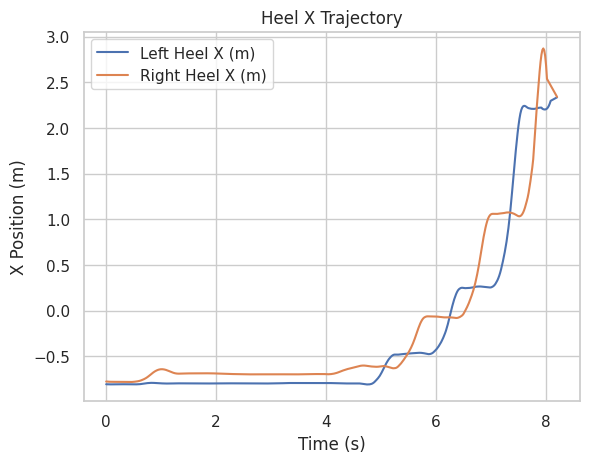

In [40]:
# === PLOT TRAJECTORY ===
for foot in ['Left', 'Right']:
    arr = heel_data[foot]
    if len(arr) > 0:
        plt.plot(arr[:,0], arr[:,1], label=f'{foot} Heel X (m)')
plt.xlabel('Time (s)'); plt.ylabel('X Position (m)'); plt.legend(); plt.title('Heel X Trajectory'); plt.show()

# === EVENT DETECTION (HS, TO) ===
def is_local_min(y, i, w): return all(y[i] < y[j] for j in range(i-w, i+w+1) if j != i and 0 <= j < len(y))
def is_local_max(y, i, w): return all(y[i] > y[j] for j in range(i-w, i+w+1) if j != i and 0 <= j < len(y))

window = 5
events = []
for foot in ['Left', 'Right']:
    arr = heel_data[foot]
    if len(arr) < window: continue
    t, x, y = arr[:,0], arr[:,1], arr[:,2]
    for i in range(window, len(y)-window):
        if is_local_min(y, i, window):
            events.append({'event': 'HS', 'foot': foot, 't': t[i], 'x': x[i], 'y': y[i]})
        elif is_local_max(y, i, window):
            events.append({'event': 'TO', 'foot': foot, 't': t[i], 'x': x[i], 'y': y[i]})
df = pd.DataFrame(events)


In [58]:
from sklearn.decomposition import PCA

# === Build Heel Events ===
events = []
for foot in ['Left', 'Right']:
    arr = heel_data[foot]
    if len(arr):
        t, x, y = arr[:, 0], arr[:, 1], arr[:, 2]
        for ti, xi in detect_hs(t, x):
            yi = y[np.argmin(np.abs(t - ti))]
            events.append({'foot': foot, 't': ti, 'x': xi, 'y': yi})

# === Gait Metric Computation ===
df = pd.DataFrame(events).sort_values('t').reset_index(drop=True)
metrics = {}

# Cycle Times
for foot in ['Left', 'Right']:
    times = df[df['foot'] == foot]['t'].values
    if len(times) >= 2:
        metrics[f'Cycle Time ({foot})'] = np.mean(np.diff(times))

# Stride Length
stride_lengths = []
for foot in ['Left', 'Right']:
    steps = df[df['foot'] == foot].reset_index(drop=True)
    for i in range(len(steps)-1):
        t1, t2 = steps.loc[i, 't'], steps.loc[i+1, 't']
        inter = df[(df['t'] > t1) & (df['t'] < t2) & (df['foot'] != foot)]
        if not inter.empty:
            dx = steps.loc[i+1, 'x'] - steps.loc[i, 'x']
            dy = steps.loc[i+1, 'y'] - steps.loc[i, 'y']
            d = np.hypot(dx, dy)
            if d > 0.7:
                stride_lengths.append(d)
if stride_lengths:
    metrics['Average Stride Length (m)'] = np.median(stride_lengths)

# Gait Speed
if 'Average Stride Length (m)' in metrics and any('Cycle Time' in k for k in metrics):
    avg_ct = np.mean([v for k, v in metrics.items() if 'Cycle Time' in k])
    metrics['Gait Speed (m/s)'] = metrics['Average Stride Length (m)'] / avg_ct

# Step Width via PCA
if len(df) > 3:

    coords = df[['x', 'y']].values
    coords -= coords.mean(axis=0)
    pca = PCA(n_components=2).fit(coords)

    side_axis = pca.components_[1]

    widths = []
    lefts = df[df['foot'] == 'Left'].reset_index(drop=True)
    rights = df[df['foot'] == 'Right'].reset_index(drop=True)

    i, j = 0, 0
    while i < len(lefts) and j < len(rights):
        tL, tR = lefts.loc[i, 't'], rights.loc[j, 't']
        if abs(tL - tR) < 0.3:
            vec = np.array([
                lefts.loc[i, 'x'] - rights.loc[j, 'x'],
                lefts.loc[i, 'y'] - rights.loc[j, 'y']
            ])
            width = np.abs(np.dot(vec, side_axis))
            widths.append(width)
            i += 1
            j += 1
        elif tL < tR:
            i += 1
        else:
            j += 1

if widths:
    metrics['Average Step Width (m)'] = np.mean(widths)

df_filtered = []
min_gap = 0.5  # seconds
for foot in ['Left', 'Right']:
    hs = df[df['foot'] == foot].sort_values('t')
    last_t = -np.inf
    for _, row in hs.iterrows():
        if row['t'] - last_t > min_gap:
            df_filtered.append(row)
            last_t = row['t']
df = pd.DataFrame(df_filtered).sort_values('t').reset_index(drop=True)

# Cadence
if len(df) > 1:
    duration = df['t'].max() - df['t'].min()
    metrics['Cadence (steps/min)'] = len(df) / duration * 60

# === Ground Truth Comparison ===
ground_truth = {
    'Gait Speed (m/s)': 1.21,
    'Average Stride Length (m)': 1.4,
    'Cadence (steps/min)': 102.9,
    'Average Step Width (m)': 0.12
}

print("\n=== Gait Metrics ===")
for k, v in metrics.items():
    print(f"{k}: {v:.3f}")

print("\n=== Accuracy Check ===")
for k, gt in ground_truth.items():
    pred = metrics.get(k)
    if pred is not None:
        err = abs(pred - gt) / gt * 100
        print(f"{k}: Predicted={pred:.3f}, Ground Truth={gt:.3f}, Error={err:.2f}%")
    else:
        print(f"{k}: Not computed")




=== Gait Metrics ===
Cycle Time (Left): 1.096
Cycle Time (Right): 1.162
Average Stride Length (m): 1.370
Gait Speed (m/s): 1.214
Average Step Width (m): 0.050
Cadence (steps/min): 117.301

=== Accuracy Check ===
Gait Speed (m/s): Predicted=1.214, Ground Truth=1.210, Error=0.30%
Average Stride Length (m): Predicted=1.370, Ground Truth=1.400, Error=2.13%
Cadence (steps/min): Predicted=117.301, Ground Truth=102.900, Error=13.99%
Average Step Width (m): Predicted=0.050, Ground Truth=0.120, Error=58.39%


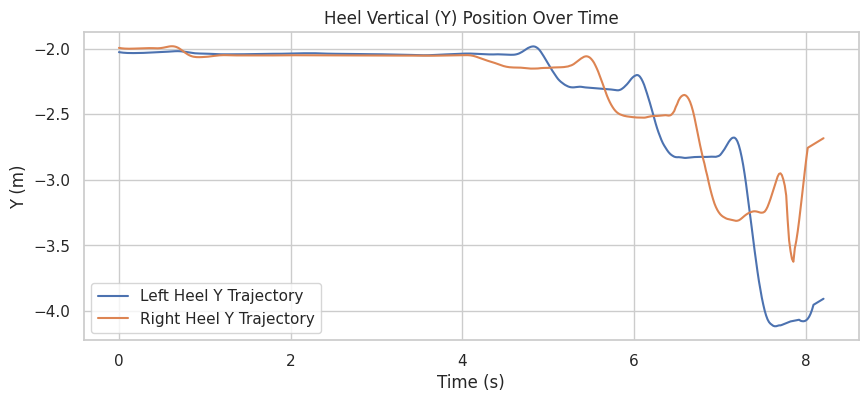

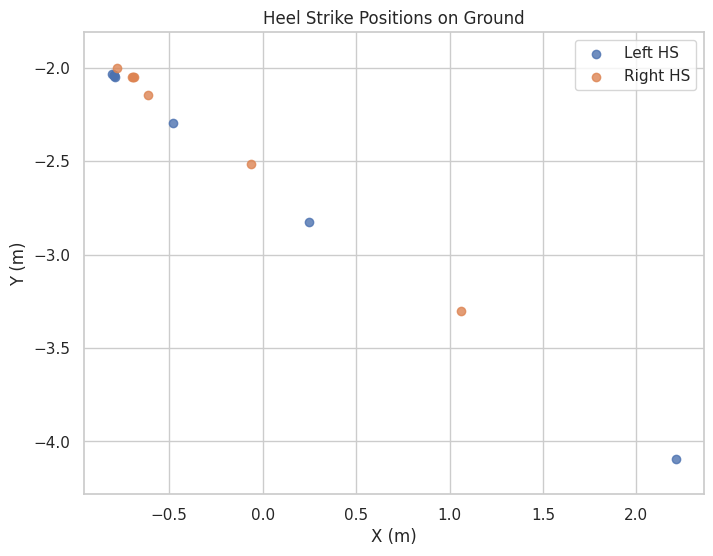

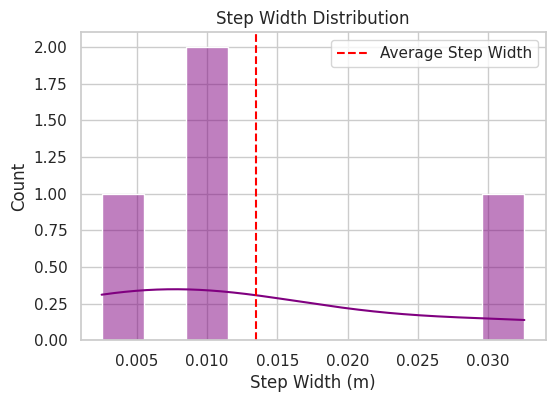

In [60]:
# === VISUALIZATIONS ===
import seaborn as sns
sns.set(style="whitegrid")

# 1. Heel trajectory over time
plt.figure(figsize=(10, 4))
for foot in ['Left', 'Right']:
    arr = np.array(heel_data[foot])
    if len(arr):
        plt.plot(arr[:,0], arr[:,2], label=f'{foot} Heel Y Trajectory')
plt.title("Heel Vertical (Y) Position Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Y (m)")
plt.legend()
plt.grid(True)
plt.show()

# 2. Heel strike scatter in 2D space
plt.figure(figsize=(8, 6))
for foot in ['Left', 'Right']:
    hs = df[df['foot'] == foot]
    plt.scatter(hs['x'], hs['y'], label=f'{foot} HS', alpha=0.8)
plt.title("Heel Strike Positions on Ground")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# 3. Step width distribution
if 'Average Step Width (m)' in metrics:
    plt.figure(figsize=(6, 4))
    sns.histplot(widths, kde=True, bins=10, color='purple')
    plt.axvline(metrics['Average Step Width (m)'], color='red', linestyle='--', label='Average Step Width')
    plt.title("Step Width Distribution")
    plt.xlabel("Step Width (m)")
    plt.legend()
    plt.grid(True)